## 1, ライブラリをインポート

In [12]:
import os, io, re
import cv2
import glob
import pickle
import shap
import copy
import optuna
import graphviz
import pydotplus
import lightgbm as lgb
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
font = {'family' : 'meiryo'}
plt.rc('font', **font)

In [13]:
from PIL import Image
from functools import partial
from pycm import ConfusionMatrix

from sklearn.externals.six import StringIO
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn import tree

import keras.backend as K
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.models import Model, load_model, Input
from keras.layers.core import Dense
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import random_rotation, random_shift, random_zoom, img_to_array, array_to_img

In [14]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 477950683690473603,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4937233203
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17422615763766773088
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

## 2, 学習データを前処理

In [15]:
for i,file in enumerate(os.listdir("./csv/")):
    if i == 0:
        df = pd.read_csv("./csv/" + file, encoding="SJIS")
    else:
        df = pd.concat([df,pd.read_csv("./csv/" +file, encoding="SJIS")])
        
df.columns = ["image","front","close","background","focus","cute","position","brightness","plural","care"]
df = df.reset_index(drop=True)
df["image"] = [("00000" + i) for i in df["image"]]
df

,image,front,close,background,focus,cute,position,brightness,plural,care
0,00000025_018.jpg,5,5,5,4,2,4,2,0,0
1,00000025_022.jpg,5,4,3,4,3,4,2,0,0
2,00000025_029.jpg,3,3,3,5,4,3,2,0,1
3,00000026_001.jpg,5,3,2,4,4,3,3,0,1
4,00000026_008.jpg,5,3,4,5,3,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...
695,00000011_025.jpg,4,3,4,5,4,3,3,2,0
696,00000011_027.jpg,5,4,2,4,4,3,3,0,0
697,00000012_010.jpg,5,3,5,5,5,3,3,0,1
698,00000012_022.jpg,3,3,4,3,3,4,3,0,0


Data must have variance to compute a kernel density estimate.


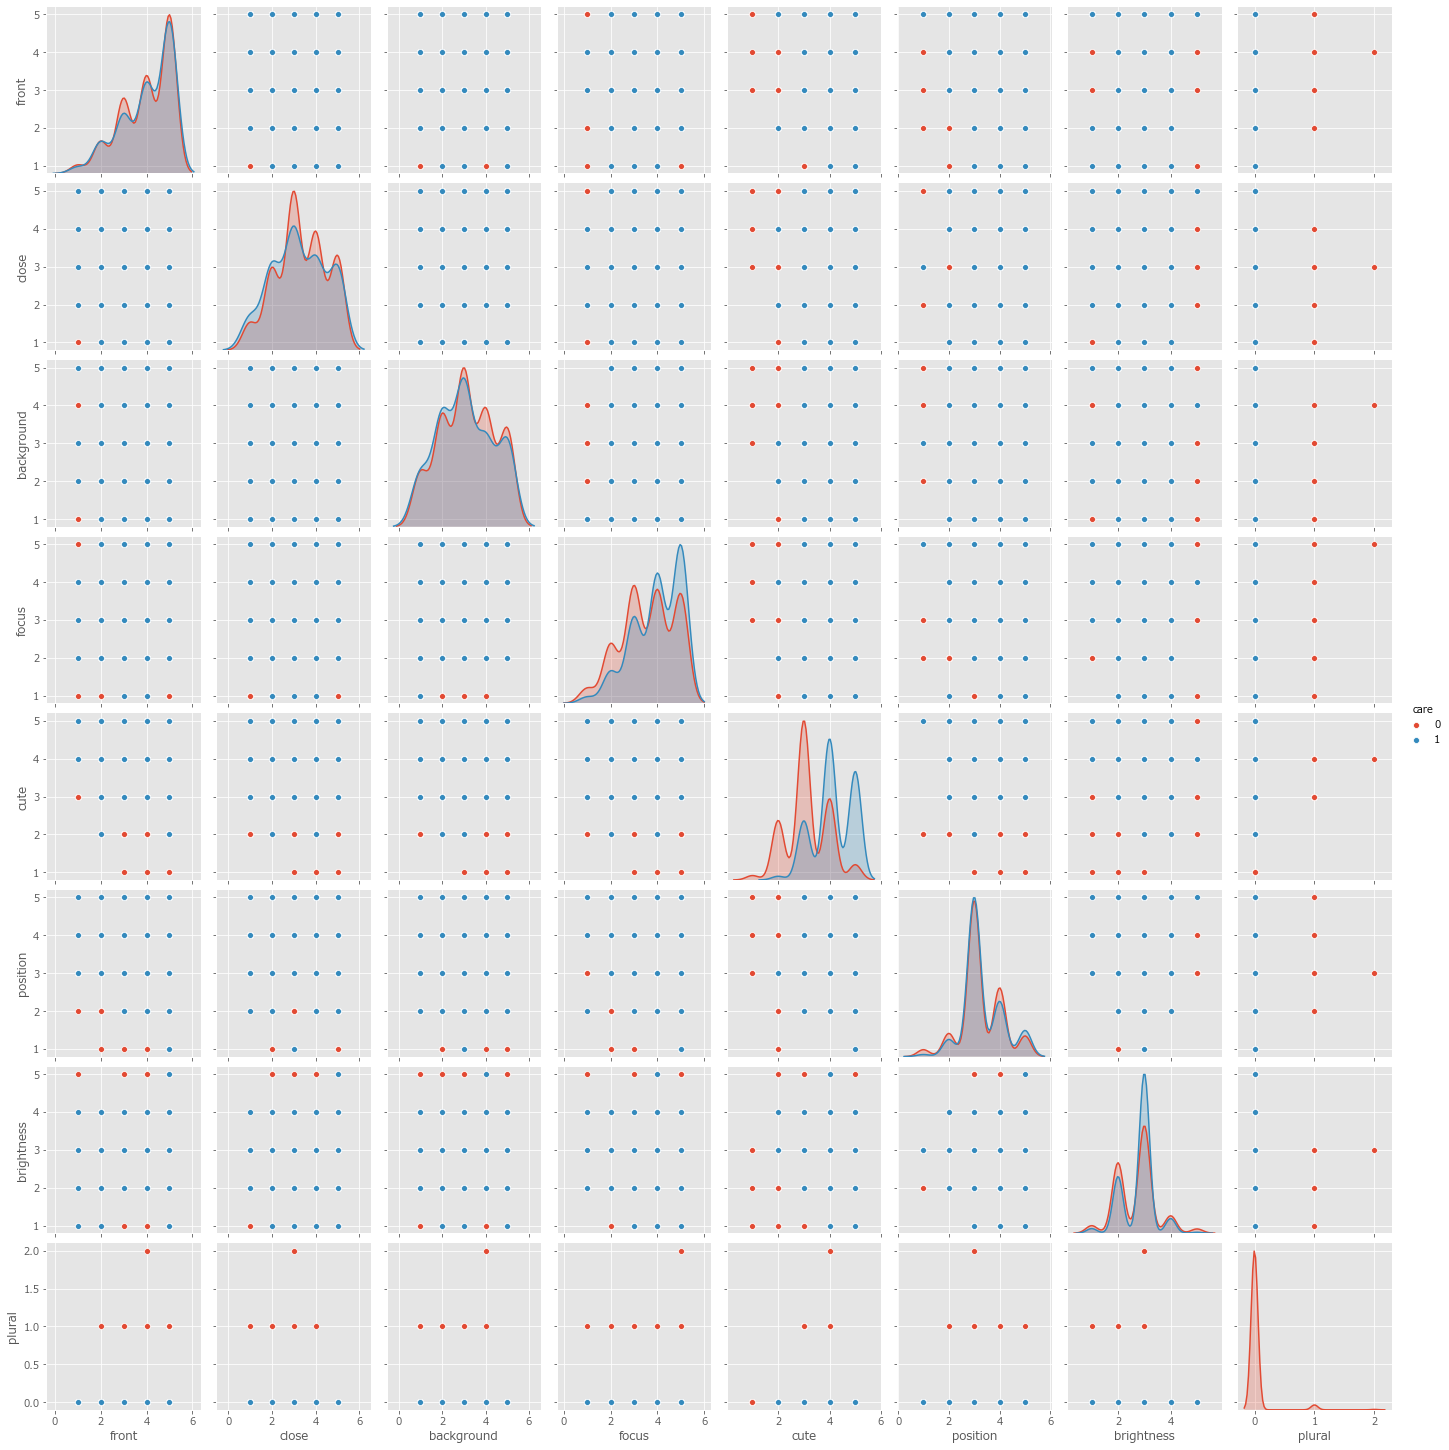

In [16]:
#離散なのに散布図です・・・欲しいのは対角線に表示されている確率密度です。
g = sns.pairplot(df.drop("image",axis=1),hue="care")
g.fig.set_figheight(20)
g.fig.set_figwidth(20)

In [17]:
#水増しフラグ
padding_flag = True

In [18]:
image_size=100
X=[]

for image_path in df["image"]:
    #画像ファイル取得
    img_file = glob.glob("./image/" + image_path)
    if not img_file:
        print(image_path)
        continue
    image = Image.open(img_file[0])
    image = image.convert("RGB")
    image = image.resize((image_size, image_size))
    X.append(np.array(image))
    
del image

## 3, 小モデル作成

In [19]:
def create_model1():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = 3, activation="relu", input_shape=(image_size,image_size,3)))
    model.add(Conv2D(16, kernel_size = 3, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, kernel_size = 3, activation="relu"))
    model.add(Conv2D(32, kernel_size = 3, activation="relu"))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, kernel_size = 3, activation="relu"))
    model.add(Conv2D(64, kernel_size = 3, activation="relu"))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [20]:
def create_model2():
    model = Sequential()
    model.add(Conv2D(32, kernel_size = 4, activation="relu", input_shape=(image_size,image_size,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [21]:
def create_model_vgg():
    base_model=VGG16(weights='imagenet',include_top=False,
                 input_tensor=Input(shape=(image_size,image_size,3)))
    x = base_model.output
    #x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.2)(x)
    prediction = Dense(1)(x)

    for layer in base_model.layers[:15]:
        layer.trainable=False
    
    return Model(inputs=base_model.input,outputs=prediction)

In [27]:
def column_predict(X_train,X_valid,y_train,y_valid,column):
    
    sess = tf.InteractiveSession()
    
    model = create_model_vgg()
    callbacks = [ReduceLROnPlateau(monitor='loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='loss', patience=10)]
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    model.summary()
    
    hist = model.fit(X_train, y_train, epochs=15, batch_size=64,verbose=1,callbacks=callbacks)
    pickle.dump(model,open("model/model_" + str(column) + ".sav","wb"))
    
    pred = model.predict(X_valid)
    MSE_pred = mean_squared_error(pred, y_valid)

    mean_pred = np.full(len(y_valid), y_train.mean())
    MSE_mean = mean_squared_error(mean_pred, y_valid)
    
    fig = plt.figure(figsize=(12, 16))
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(column, fontsize=20)
    
    ax1 = fig.add_subplot(211,
                          title="Loss",
                          ylabel="Loss",
                          xlabel="Epoch")
    ax1.plot(hist.history["loss"])
    ax1.legend(["Train", "Test"], loc="upper left")

    ax2 = fig.add_subplot(212,
                          title="pred(mse):" + str(MSE_pred)[:5] + "\n" +"baseline(mse):" + str(MSE_mean)[:5],
                          ylabel="Score",
                          xlabel="ID")
    ax2.plot(y_valid, label="Actual")
    ax2.plot(pred, label="Pred")
    ax2.plot(mean_pred, label="Mean")
    ax2.legend(loc="upper right")
    
    plt.show()

    
    with tf.Session() as sess:
         sess.run(tf.global_variables_initializer())
    
    explainer = shap.DeepExplainer(model, (X_train[0:20]*255))
    for i in range(3):
        index_names = np.array("True:" + str(y_valid[i]) + "\n" + "Pred:" + str(pred[i][0])[:4]).reshape(1,1)
        shap_values = explainer.shap_values(X_valid[[i]]*255)
        shap.image_plot(shap_values, X_valid[[i]], index_names)
        plt.gcf().set_size_inches(20, 20)
    
    return(pred)
    

In [28]:
sess = tf.InteractiveSession()
sess.close()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

In [29]:
X = np.array(X)
Y = np.array(df[["front","close","background","focus","cute","position","brightness","plural","care"]])

X_train, X_valid, y_train, y_valid = train_test_split(X,Y,random_state = 0,test_size = 0.2)

y_train,care_train = np.hsplit(y_train, [len(y_train[0])-1])
y_valid,care_valid = np.hsplit(y_valid, [len(y_valid[0])-1])

In [30]:
#レーダーチャート関数
def plot_polar(labels, values, values2 = np.array([])):
    angles = np.linspace(0, 2 * np.pi, len(labels) + 1, endpoint=True)
    values = np.concatenate((values, [values[0]]))  # 閉じた多角形にする
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, values, 'o-', label="True")  # 外枠
    if len(values2) != 0:
        values2 = np.concatenate((values2, [values2[0]]))  # 閉じた多角形にする
        ax.plot(angles, values2, 'o-', label="Pred")
        ax.legend(loc=(0.01, 0.01))
    ax.fill(angles, values, alpha=0.25)  # 塗りつぶし
    ax.set_thetagrids(angles[:-1] * 180 / np.pi, labels)  # 軸ラベル
    ax.set_rlim(0 ,5)
    plt.show()

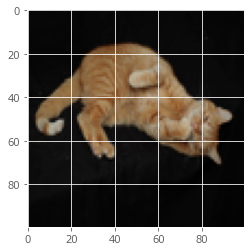

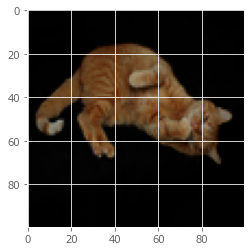

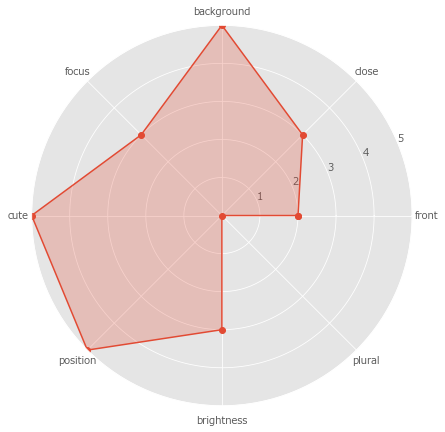

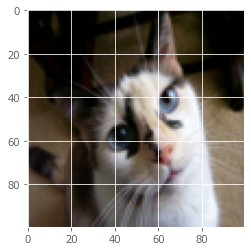

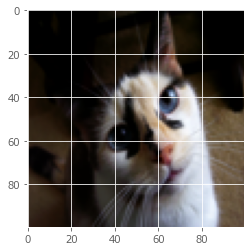

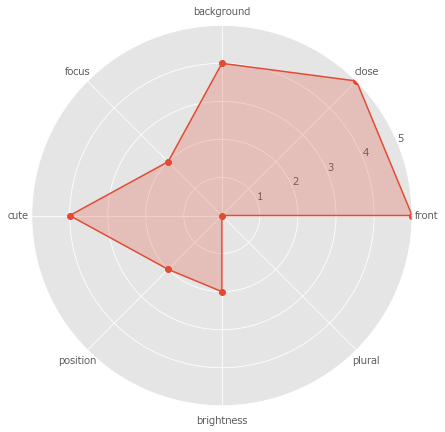

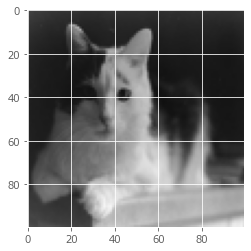

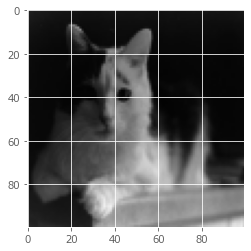

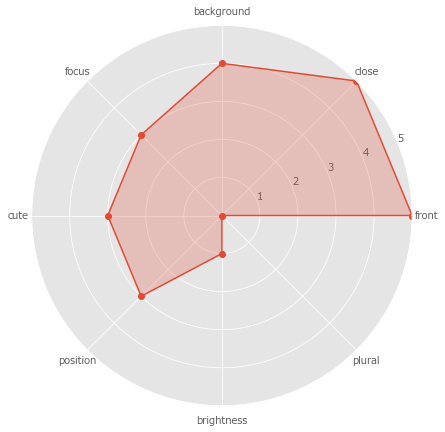

In [31]:
if padding_flag:
    
    #水増し(回転)を入れる予定
    #水増し(ガンマ変換)
    X_train = list(X_train)
    
    gamma = 0.65
    look_up_table = np.ones((256, 1), dtype = 'uint8' ) * 0
    for i in range(256):
        look_up_table[i][0] = 255 * pow(float(i) / 255, 1.0 / gamma)
    X_train_gamma = []
    X_train_rotate_r = []
    X_train_rotate_l = []
    X_train_rotate_r2 = []
    X_train_rotate_l2 = []
    
    
    for i in range(len(X_train)):
        img = np.array(X_train[i]).transpose(1, 2, 0)
        img_gamma = cv2.LUT(img, look_up_table)
        X_train_gamma.append(list(img_gamma.transpose(2,0,1)))
        
        rotate_r = copy.deepcopy(X_train[i])
        rotate_l = copy.deepcopy(X_train[i])
        rotate_r2 = copy.deepcopy(X_train[i])
        rotate_l2 = copy.deepcopy(X_train[i])
        
        X_train_rotate_r.append(img_to_array(array_to_img(rotate_r).rotate(3)).astype('int32'))
        X_train_rotate_l.append(img_to_array(array_to_img(rotate_l).rotate(360 - 3)).astype('int32'))
        X_train_rotate_r2.append(img_to_array(array_to_img(rotate_r2).rotate(5)).astype('int32'))
        X_train_rotate_l2.append(img_to_array(array_to_img(rotate_l2).rotate(360 - 5)).astype('int32'))


    X_train_gamma = np.array(X_train_gamma)
    X_train_rotate_r = np.array(X_train_rotate_r)
    X_train_rotate_l = np.array(X_train_rotate_l)
    X_train_rotate_r2 = np.array(X_train_rotate_r2)
    X_train_rotate_l2 = np.array(X_train_rotate_l2)
    
    X_train = np.vstack((X_train,X_train_gamma))
    X_train = np.vstack((X_train,X_train_rotate_r))
    X_train = np.vstack((X_train,X_train_rotate_l))
    X_train = np.vstack((X_train,X_train_rotate_r2))
    X_train = np.vstack((X_train,X_train_rotate_l2))
    
    #ガンマ変換によるラベル修正(明暗値を1下げる)
    y_train_gamma = copy.deepcopy(y_train)
    y_train_rotate_r = copy.deepcopy(y_train)
    y_train_rotate_l = copy.deepcopy(y_train)
    y_train_rotate_r2 = copy.deepcopy(y_train)
    y_train_rotate_l2 = copy.deepcopy(y_train)
    
    for i in range(len(y_train_gamma)):
        brightness = y_train_gamma[i][6]
        if brightness != 1:
            brightness -= 1
        y_train_gamma[i][6] = brightness
    y_train = np.append(y_train,y_train_gamma,axis=0)
    y_train = np.append(y_train,y_train_rotate_r,axis=0)
    y_train = np.append(y_train,y_train_rotate_l,axis=0)
    y_train = np.append(y_train,y_train_rotate_r2,axis=0)
    y_train = np.append(y_train,y_train_rotate_l2,axis=0)
    
    #スコア、解像度、ガンマ変換を確認
    for i in range(3):
        plt.imshow(X_train[i])
        plt.show()
        
        plt.imshow(X_train[i + int(len(X_train)/6)])
        plt.show()
        
        plot_polar(["front","close","background","focus","cute","position","brightness","plural"], y_train[i])

X_train = X_train.astype("float32") / 255
X_valid = X_valid.astype("float32") / 255

In [32]:
#predict_df = pd.DataFrame(index=["MSE_pred","MSE_mean"])
pred_list = []
for i,column in enumerate(["front","close","background","focus","cute","position","brightness","plural"]):
    print("============================================================")
    pred_list.append(column_predict(X_train,X_valid,y_train.T[i],y_valid.T[i],column))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
___________________________________________

UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node block1_conv1/convolution}}]]
	 [[Mean/_271]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node block1_conv1/convolution}}]]
0 successful operations.
0 derived errors ignored.

## 4, 大モデル作成

In [77]:
X2 = df[["front","close","background","focus","cute","position","brightness","plural"]]
Y2 = df["care"].values

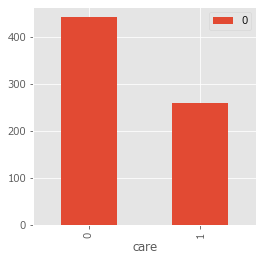

In [78]:
#偏りはsample_weightで調整する予定
pd.DataFrame(df.groupby("care").size()).plot(kind = "bar", figsize = (4, 4))
plt.show()

In [79]:
#最適化される関数
def objective(x,y,trial):
    params={
        "num_leaves":trial.suggest_int("num_leaves",30,400),
        "learning_rate":trial.suggest_uniform("learning_rate",0.1,3.0),
        "feature_fraction":trial.suggest_uniform("feature_fraction",0.1,1.0),
        "max_depth":trial.suggest_int("max_depth",4,12),
        "objective":trial.suggest_categorical("objective",["binary"]),
        "random_state":trial.suggest_int("random_state",0,0)
    }
    
    score = 0
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
    for train_index,test_index in kf.split(x,y):
        X_train = x.iloc[train_index]
        X_test = x.iloc[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train,y_train)
        pred = model.predict(X_test)
        score += accuracy_score(y_test,pred)
    return score    

In [80]:
def last_predict(X,Y,image):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state = 0,test_size = 0.2)

    evals_result = {}
    study = optuna.create_study(direction="maximize",sampler=optuna.samplers.RandomSampler(seed=0))
    study.optimize(partial(objective,X_train,y_train),n_trials=200)
    model = lgb.LGBMClassifier(**study.best_params)
    model.fit(X_train, y_train, callbacks=[lgb.record_evaluation(evals_result)])
    pickle.dump(model,open("model/model_lgb.sav","wb"))
    
    pred = model.predict(X_test)
    acc = accuracy_score(pred, y_test)
    print("acc:" + str(acc)[:4])
    print()
    print("confusion_matrix:")
    cm = ConfusionMatrix(pred, y_test)
    cm.print_matrix()
    
    plt.figure(figsize=(8, 4))
    plt.plot(y_test, label="Actual")
    plt.plot(pred, c="b", label="pred", alpha=0.6)
    plt.legend(loc="upper right")
    plt.show()
    
    Xcolumns = X.columns
    features = Xcolumns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    #importance
    plt.figure(figsize=(8,4))
    plt.title("importance")
    plt.barh(range(len(indices)),importances[indices],align="center")
    plt.yticks(range(len(indices)),features[indices])
    plt.show()
    
    #shap
    explainer = shap.TreeExplainer(model,X)    
    for i in range(3):
        print(str(i))
        plt.imshow(image[i])
        plt.show()
        
        shap_values = explainer.shap_values(X.loc[[i]])
        shap.force_plot(explainer.expected_value, 
                    shap_values, 
                    X.loc[[i]], 
                    matplotlib=True,
                    )

In [86]:
def last_predict_dt(X,Y,image):
    from IPython.display import Image
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state = 0,test_size = 0.2)

    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    pickle.dump(model,open("model/model_dt.sav","wb"))
    
    pred = model.predict(X_test)
    acc = accuracy_score(pred, y_test)
    print("acc:" + str(acc)[:4])
    print()
    print("confusion_matrix:")
    cm = ConfusionMatrix(pred, y_test)
    cm.print_matrix()
    
    plt.figure(figsize=(8, 4))
    plt.plot(y_test, label="Actual")
    plt.plot(pred, c="b", label="pred", alpha=0.6)
    plt.legend(loc="upper right")
    plt.show()
    
    Xcolumns = X.columns
    features = Xcolumns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    #importance
    plt.figure(figsize=(8,4))
    plt.title("importance")
    plt.barh(range(len(indices)),importances[indices],align="center")
    plt.yticks(range(len(indices)),features[indices])
    plt.show()
    
    #shap
    explainer = shap.TreeExplainer(model)    
    for i in range(3):
        print(str(i))
        plt.imshow(image[i])
        plt.show()
        
        shap_values = explainer.shap_values(X.loc[[i]])
        shap.force_plot(explainer.expected_value[1], 
                    shap_values[1], 
                    X.loc[[i]], 
                    matplotlib=True,
                    )
    
    #決定木モデルの構造を画像出力
    dot_data = StringIO()
    tree.export_graphviz(model, 
                        class_names=["not_care","care"],
                        feature_names=["front","close","background","focus","cute","position","brightness","plural"],
                        filled=True,
                        rounded=True,
                        out_file=dot_data
                    )
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_pdf("graph1.pdf")
    Image(graph.create_png())
    graph

acc:0.74

confusion_matrix:
Predict  0        1        
Actual
0        71       22       

1        14       33       




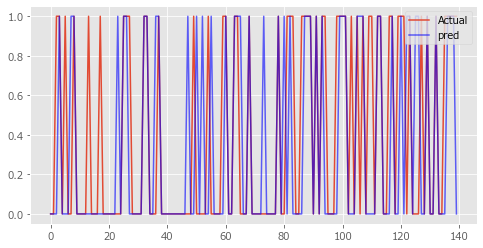

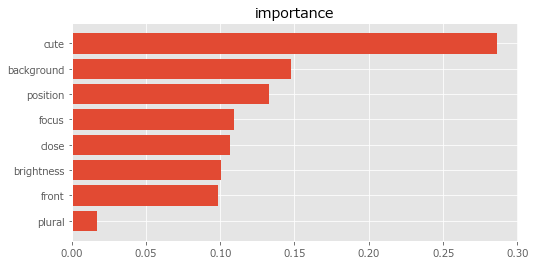

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


0


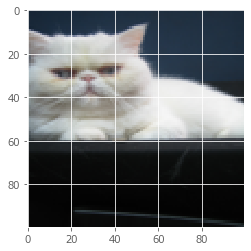

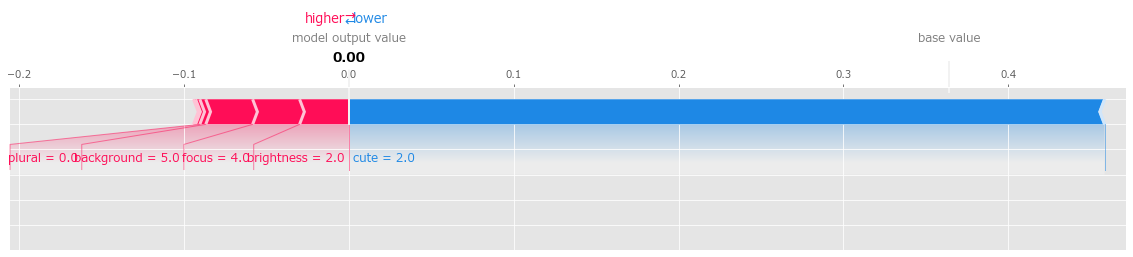

1


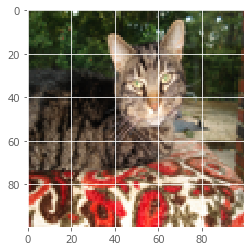

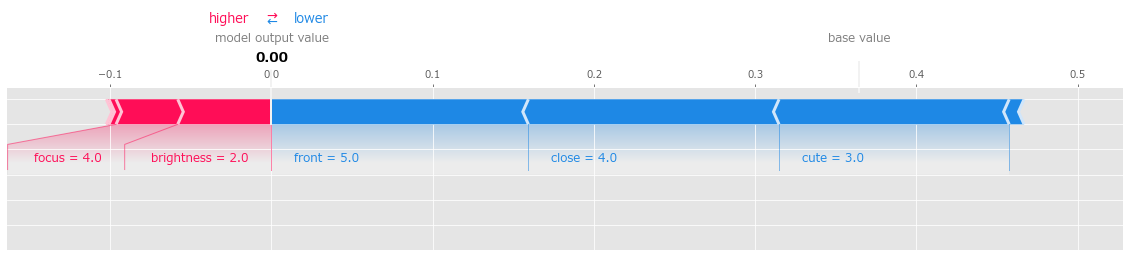

2


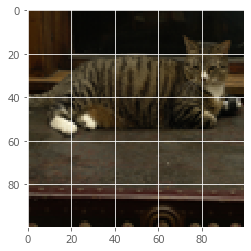

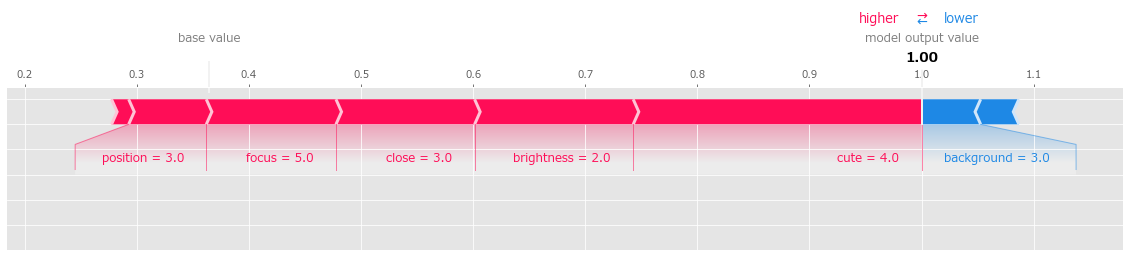

In [87]:
last_predict_dt(X2,Y2,X)

## 5, 保護有無の予想

In [57]:
#小モデルの予想結果を大モデルに投入して保護有無を予想する
model = pickle.load(open("model/model_lgb.sav","rb"))
X_pred = np.squeeze(np.array(pred_list).T)
pred = model.predict(X_pred)

print("base_acc:" + str(accuracy_score(np.zeros(len(pred)),np.squeeze(care_valid)))[:4])
print("acc:" + str(accuracy_score(pred,np.squeeze(care_valid)))[:4])
print()
print("confusion_matrix:")
cm = ConfusionMatrix(pred,np.squeeze(care_valid))
cm.print_matrix()

base_acc:0.72
acc:0.5

confusion_matrix:
Predict  0        1        
Actual
0        31       15       

1        20       4        




Setting feature_perturbation = "tree_path_dependent" because no background data was given.


care_true:0
care_pred:1


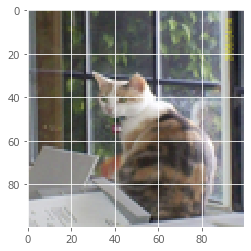

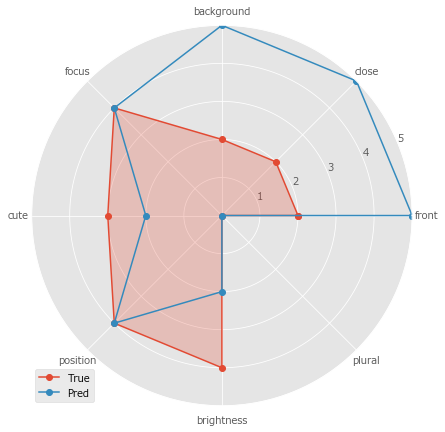

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


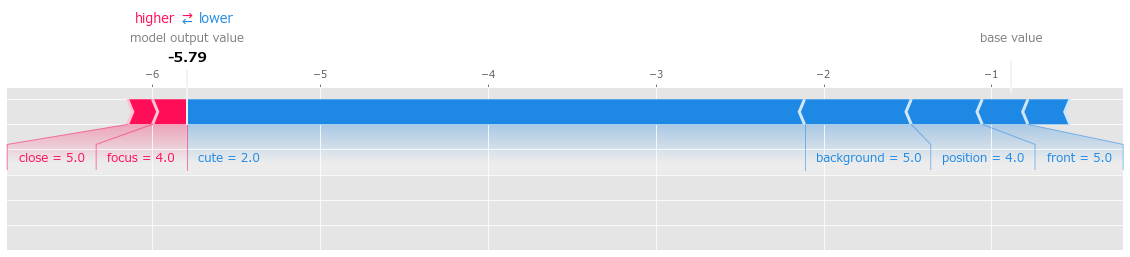

care_true:0
care_pred:0


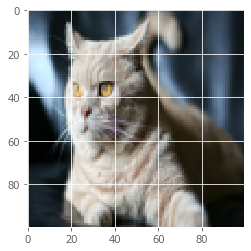

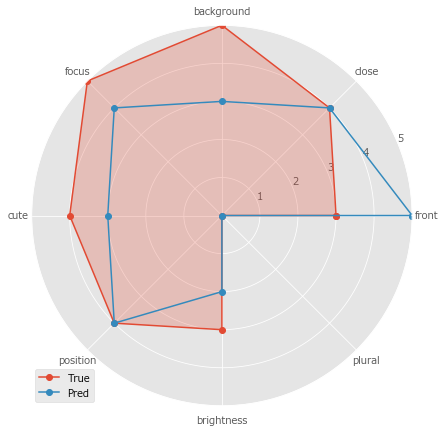

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


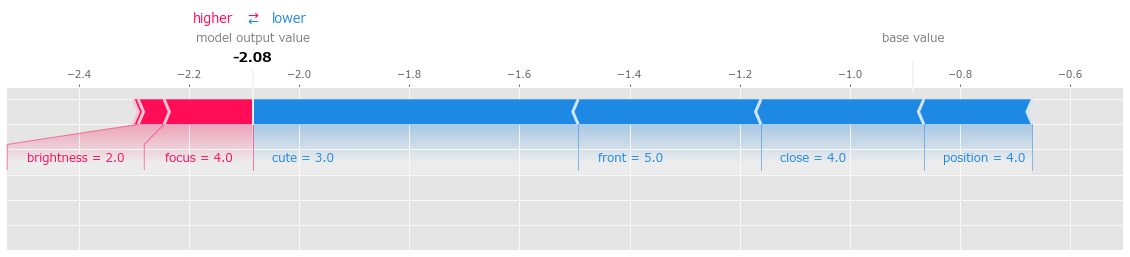

care_true:1
care_pred:0


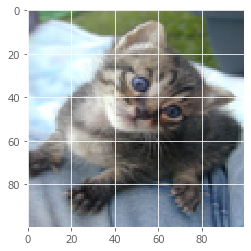

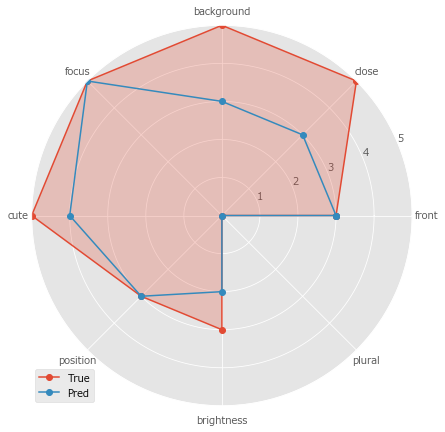

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


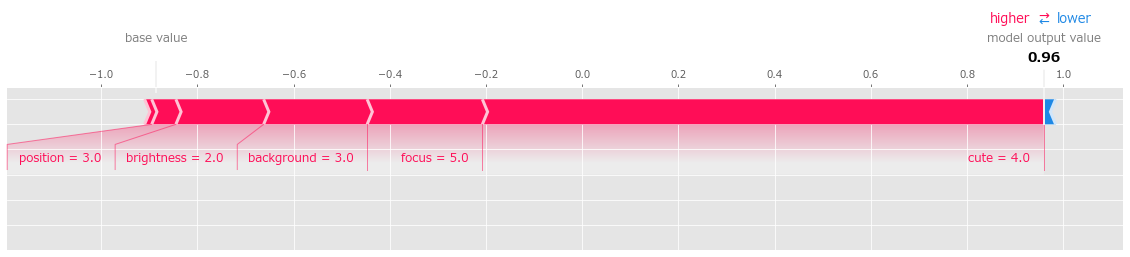

care_true:1
care_pred:0


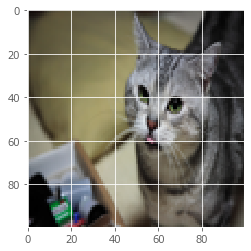

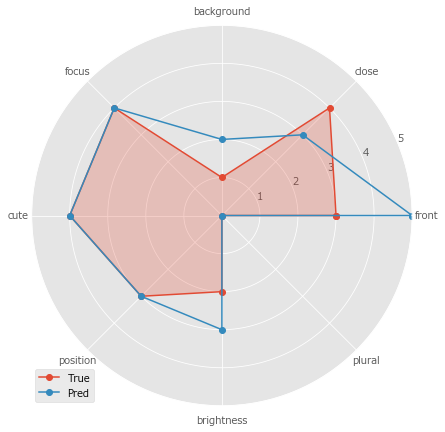

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


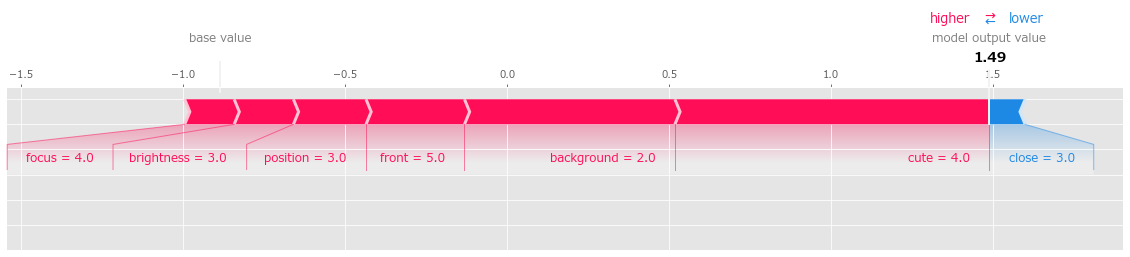

care_true:0
care_pred:1


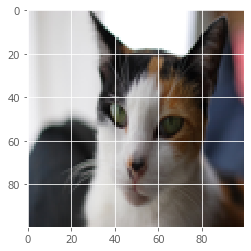

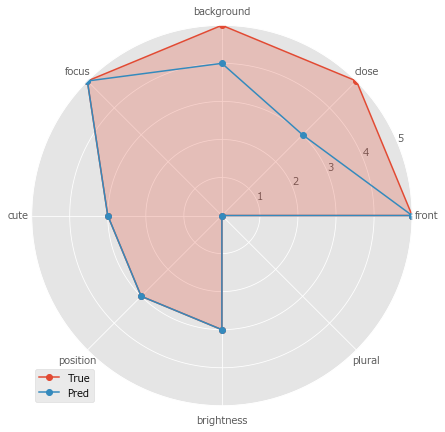

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


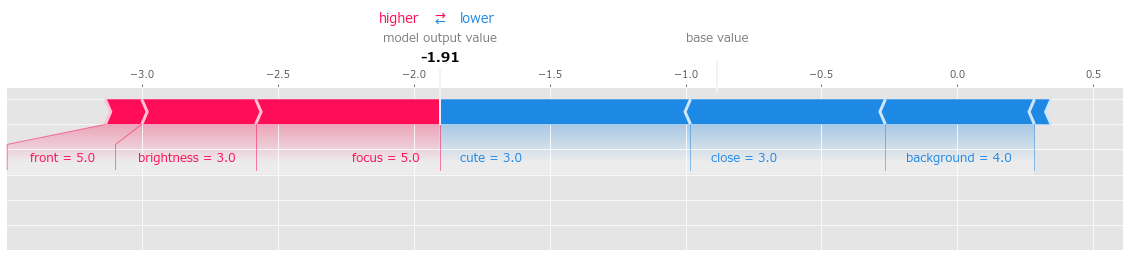

In [58]:
explainer = shap.TreeExplainer(model)
sample_num = 5
for i in range(sample_num):
    print("care_true:" + str(np.squeeze(care_valid)[i]))
    print("care_pred:" + str(pred[i]))
    
    #画像
    plt.imshow(X_valid[i])
    plt.show()
    
    #レーダーチャート
    plot_polar(["front","close","background","focus","cute","position","brightness","plural"], y_valid[i], np.squeeze(X2.loc[[i]].values))
    
    #SHAP
    shap_values = explainer.shap_values(X2)
    shap.force_plot(explainer.expected_value[1], 
                shap_values[1][i],
                X2.loc[[i]], 
                matplotlib=True,
                )
    print("=======================================")

In [59]:
explainer.expected_value

[0.8852032965372665, -0.8852032965372665]

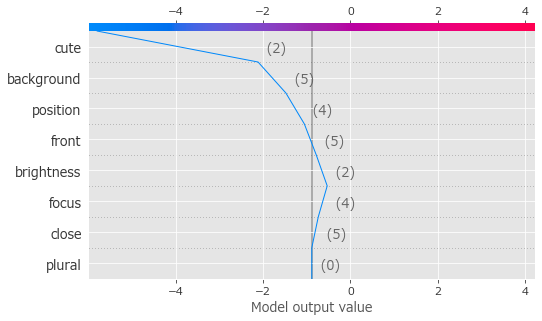

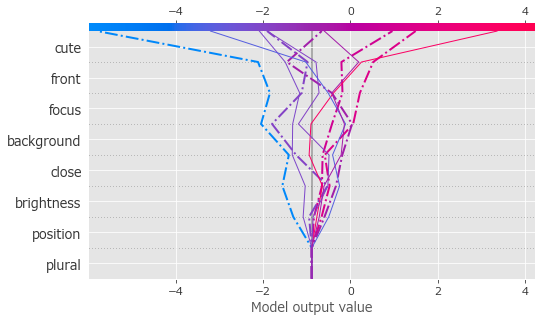

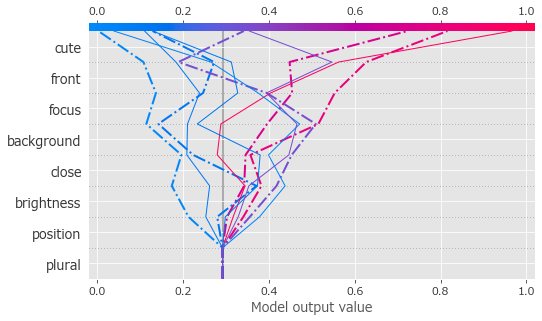

In [60]:
sample_num = 10

#予想が外れたら点線で表示
misclassified = (pred[0:sample_num] != np.squeeze(care_valid)[0:sample_num])

#サンプルが1つの場合
shap.decision_plot(explainer.expected_value[1], shap_values[1][0:1], X2[0:1])

#サンプルが複数の場合
shap.decision_plot(explainer.expected_value[1], shap_values[1][0:sample_num], X2[0:sample_num],highlight=misclassified)

#オッズ比を確率に
shap.decision_plot(explainer.expected_value[1], shap_values[1][0:sample_num], X2[0:sample_num], link='logit', highlight=misclassified)

## 以下考察中

In [121]:
#高速版(未完成)
layer = 8

feed_dict = dict(zip([model.layers[0].input], [X.copy() * 255]))

In [122]:
feed_dict

{<tf.Tensor 'conv2d_38_input:0' shape=(?, 60, 60, 3) dtype=float32>: array([[[[0.09019608, 0.14117648, 0.20392157],
          [0.09411765, 0.14509805, 0.20392157],
          [0.09411765, 0.14901961, 0.20784314],
          ...,
          [0.10980392, 0.17254902, 0.23529412],
          [0.10980392, 0.17254902, 0.23137255],
          [0.10588235, 0.16862746, 0.22745098]],
 
         [[0.09411765, 0.14509805, 0.20392157],
          [0.09411765, 0.14509805, 0.20784314],
          [0.09411765, 0.14901961, 0.20784314],
          ...,
          [0.11372549, 0.1764706 , 0.23529412],
          [0.10980392, 0.17254902, 0.23529412],
          [0.10980392, 0.16862746, 0.23137255]],
 
         [[0.09803922, 0.15294118, 0.21176471],
          [0.09803922, 0.14901961, 0.21176471],
          [0.09411765, 0.14901961, 0.21176471],
          ...,
          [0.11372549, 0.1764706 , 0.23529412],
          [0.11372549, 0.17254902, 0.23529412],
          [0.10980392, 0.16862746, 0.23137255]],
 
         ...,


In [123]:
temp = K.get_session().run(model.layers[layer].input, feed_dict)

In [124]:
e = shap.DeepExplainer(
    (model.layers[layer].input, model.layers[-1].output),
    temp,
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


keras is no longer supported, please use tf.keras instead.


AttributeError: 'list' object has no attribute 'shape'

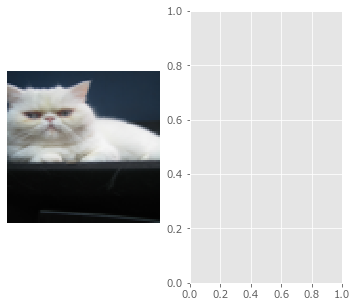

In [12]:
shap_values = e.shap_values(map2layer(X[[0]], 8), ranked_outputs=1)

shap.image_plot(shap_values, X[[0]] * 255, show=False)
plt.gcf().set_size_inches(20, 20)